# Test my crowding code as if in the driver

In [1]:
import sys
sys.path.insert(0, '/Users/ageller/WORK/LSST/onGitHub/EBLSST/code')
from LSSTEBClusterWorker import LSSTEBClusterWorker
from OpSim import OpSim
from getClusterBinaries import getClusterBinaries

%load_ext autoreload
%autoreload 2

/Users/ageller/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/ageller/python_scripts/PySynphotData/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/ageller/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/ageller/python_scripts/PySynphotData/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))
/Users/ageller/anaconda3/lib/python3.7/site-packages/numpy/lib/npyio.py:2336: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [2]:
import pandas as pd
import numpy as np

import sys

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from jupyterthemes import jtplot
jtplot.reset()

In [3]:
GCDF = pd.read_csv("/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/clusters/GCdataForEBLSST.csv").fillna(0.)
field = GCDF.loc[GCDF['ID'] == 'NGC 6254'] #M10 GC
field

,ID,RA[hr],Dec[deg],dist[pc],rhm[pc],mass[Msun],age[Myr],[Fe/H],sigma_v0_z[km/s],OpSimID,OpSimRA[deg],OpSimDec[deg]
59,NGC 6254,16 57 09.05,-04 06 01.1,4400.0,2.495821,177431.202408,10345.238095,-1.56,6.6,2413.0,253.606593,-5.090318


In [4]:
OpS = OpSim()
OpS.dbFile = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/db/baseline2018a.db'
OpS.getCursors()

have summary cursor.
have field cursor.


In [5]:
OpS.fieldID = field['OpSimID'].values
OpS.RA = field['OpSimRA[deg]'].values
OpS.Dec = field['OpSimDec[deg]'].values
OpS.obsDates = np.full_like(OpS.fieldID, dict(), dtype=dict)
OpS.NobsDates = np.full_like(OpS.fieldID, dict(), dtype=dict)
OpS.m_5 = np.full_like(OpS.fieldID, dict(), dtype=dict)
OpS.totalNobs = np.full_like(OpS.fieldID, 0)

In [6]:
OpSimi = 0
worker = LSSTEBClusterWorker()
worker.filterFilesRoot = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/filters/'
worker.clusterName = field['ID'].values
worker.clusterMass = field['mass[Msun]'].values
worker.clusterDistance = field['dist[pc]'].values/1000.
worker.clusterMetallicity = field['[Fe/H]'].values
worker.clusterAge = field['age[Myr]'].values
worker.clusterRhm = field['rhm[pc]'].values
worker.clusterVdisp = field['sigma_v0_z[km/s]'].values
    
worker.OpSim = OpS

worker.seed = 1111

worker.initialize(OpSimi)

total number of OpSim observation dates (all filters) = 951.0


True

In [8]:
worker.galArchiveDir = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/testing/crowding/TRILEGALmodels'
#using these flags so that I don't have to download each time
worker.getGalaxy(OpSimi, deleteModel = False, downloadModel = False) 

downloaded TRILEGAL model for ID=2413.0, RA=253.606593, DEC=-5.090318, Nstars=1123859.0, Nstars/resEl=0.0017697452128999749


In [9]:
worker.n_bin = 100
clusterDat = worker.sampleCluster(OpSimi)
print(worker.clusterSampler.bcmEvolved)

sampling cluster NGC 6254
initial binary input: 1111 10345.238095238095 -1.56 100 6.6 4.0
Number of binaries 73
           tphys  kstar_1   mass0_1    mass_1       lumin_1     rad_1  \
0   10345.238095      0.0  0.560664  0.560664  1.271253e-01  0.502036   
1   10345.238095      0.0  0.554351  0.554351  1.203283e-01  0.495169   
2   10345.238095      0.0  0.291015  0.291015  1.971843e-02  0.276870   
3   10345.238095     11.0  0.782429  0.782429  2.580613e-06  0.010514   
4   10345.238095      0.0  0.255751  0.255751  1.583187e-02  0.252346   
5   10345.238095      0.0  0.299821  0.299821  2.075053e-02  0.282913   
6   10345.238095     11.0  0.543642  0.543642  6.659132e-06  0.013568   
7   10345.238095      0.0  0.652936  0.652936  2.955547e-01  0.612806   
8   10345.238095      0.0  0.202401  0.202401  1.031778e-02  0.212461   
9   10345.238095      0.0  0.295136  0.295136  2.019738e-02  0.279700   
10  10345.238095     11.0  0.630214  0.630214  5.260380e-06  0.012377   
11  10345.23

In [61]:
i = 12
line = clusterDat[i]
#change the inclination
line[12] = np.pi/2.
#change the period
line[2] = np.log10(3.47)
print(line)

EB = worker.getEB(line, OpSimi=OpSimi)

print(worker.EB.crowding.clusterRPlummer)
print(worker.EB.observable)
print(worker.EB.radius_failed, worker.EB.period_failed, worker.EB.incl_failed, worker.EB.appmag_failed)
print(worker.EB.appMagMean)

print("background flux", worker.EB.crowding.backgroundFlux)
print("background mag", worker.EB.crowding.backgroundMag)
print("light_3", worker.EB.light_3)

[0.6793102062930172 0.3818604759284212 0.5403294747908738
 0.4639047862497464 0.6513255578524976 0.3405352625408515
 0.38185879579934656 0.03320213345963863 None None None 4.4
 1.5707963267948966 5.834445529827179 1.709319556210919 None -1.56
 5647.370104573919 4241.115145597865 0.0 0.0]


            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            


getting crowding ... 
initial single input: 10345.238095238095 -1.56 99
crowding Ncluster, Ngalaxy 99 0


            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
        

            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
        

            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
        

            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
        

            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
        

            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
        

            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
        

            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
        

            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
        

            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
        

            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
        

            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
        

            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
        

            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
        

            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
        

            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]
            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
            
        

crowding mag {'u_': 17.11730563418142, 'g_': 16.79943159829201, 'r_': 16.483990695252622, 'i_': 16.292471743774872, 'z_': 16.176190508446435, 'y_': 16.109417806078827}
1.9128495433910215
True
0 0 0 0
{'u_': <Quantity 21.72022936>, 'g_': <Quantity 20.43242305>, 'r_': <Quantity 19.65215156>, 'i_': <Quantity 19.29604639>, 'z_': <Quantity 19.12421325>, 'y_': <Quantity 19.03255963>}
background flux {'u_': 4.891697690975262e-07, 'g_': 4.891697690975262e-07, 'r_': 4.891697690975262e-07, 'i_': 4.891697690975262e-07, 'z_': 4.891697690975262e-07, 'y_': 4.891697690975262e-07}
background mag {'u_': 17.11730563418142, 'g_': 16.79943159829201, 'r_': 16.483990695252622, 'i_': 16.292471743774872, 'z_': 16.176190508446435, 'y_': 16.109417806078827}
light_3 {'u_': <Quantity 69.36964806>, 'g_': <Quantity 28.39203879>, 'r_': <Quantity 18.50394578>, 'i_': <Quantity 15.90119852>, 'z_': <Quantity 15.10807372>, 'y_': <Quantity 14.7657914>}


In [62]:
print(worker.EB.crowding.xBinary, worker.EB.crowding.yBinary)
print(worker.EB.crowding.clusterNstars)
print(worker.EB.crowding.nCrowdCluster)
print(worker.EB.crowding.clusterSingles)
print(worker.EB.crowding.nCrowdGalaxy)
print(worker.EB.crowding.galaxySingles)


[0.00998946] [0.04398127]
354862.4048151847
99
           tphys  kstar_1   mass0_1    mass_1   lumin_1     rad_1  \
22  10345.238095     11.0  1.006382  1.006382  0.000003  0.007986   
78  10345.238095     11.0  0.974108  0.974108  0.000003  0.008349   
31  10345.238095     11.0  0.942556  0.942556  0.000003  0.008702   
55  10345.238095     11.0  0.942335  0.942335  0.000003  0.008705   
98  10345.238095     11.0  0.854064  0.854064  0.000004  0.009695   
21  10345.238095      1.0  0.841871  0.841871  3.325175  1.195699   
88  10345.238095     11.0  0.824729  0.824729  0.000004  0.010028   
7   10345.238095      0.0  0.821939  0.821939  2.068539  1.027593   
54  10345.238095     11.0  0.813702  0.813702  0.000004  0.010154   
82  10345.238095     11.0  0.790289  0.790289  0.000005  0.010423   
73  10345.238095     11.0  0.765569  0.765569  0.000005  0.010711   
4   10345.238095      0.0  0.763381  0.763381  0.907719  0.810928   
76  10345.238095     11.0  0.725408  0.725408  0.000005 

In [63]:
#now plot the crowding
if (worker.EB.crowding.clusterSingles is not None):
    fig,ax = plt.subplots(6,1, figsize=(5, 15), sharex = True)
    for i,f in enumerate(worker.filters):
        cmp = ax[i].pcolormesh(worker.EB.crowding.xgrid, worker.EB.crowding.ygrid, 
                         worker.EB.crowding.fluxgrid[f], cmap='plasma')#, norm=colors.LogNorm())
        ax[i].set_aspect(1)
        #ax[i].set_title(f)
        ax[i].scatter(worker.EB.crowding.clusterSingles['xAng'], 
                      worker.EB.crowding.clusterSingles['yAng'], s=3, color='black')
        ax[i].set_ylabel(r'$\Delta y$ (arcsec)', fontsize=14)
        ax[i].yaxis.set_ticks_position('right')
        ax[i].yaxis.set_label_position('right')
        ax[i].set_xlim(-1.5, 1.5)
        ax[i].set_ylim(-1.5, 1.5)
        ax[i].set_yticks([-1,0,1])
    ax[5].set_xlabel(r'$\Delta x$ (arcsec)', fontsize=14)
    plt.subplots_adjust(hspace=0.05)
    
    # Now adding the colorbar
#     cbaxes = fig.add_axes([0.92, 0.33, 0.01, 0.32]) 
#     cbar = plt.colorbar(cmp, cax = cbaxes) 
#     cbaxes.set_ylabel('Flux')

    fig.savefig('M10crowding_pixels.pdf', format = 'pdf', bbox_inches = 'tight')

In [64]:
if (worker.EB.crowding.galaxySingles is not None):
    f,ax = plt.subplots(1,6, figsize=(15, 5))
    for i,f in enumerate(worker.filters):
        ax[i].pcolormesh(worker.EB.crowding.xgrid, worker.EB.crowding.ygrid, 
                         worker.EB.crowding.fluxgrid[f])#, norm=colors.LogNorm())
        ax[i].set_aspect(1)
        ax[i].set_title(f)
        ax[i].scatter(worker.EB.crowding.galaxySingles['xAng'], 
                      worker.EB.crowding.galaxySingles['yAng'], s=3, color='white')

In [65]:
print(worker.EB.light_3)

{'u_': <Quantity 69.36964806>, 'g_': <Quantity 28.39203879>, 'r_': <Quantity 18.50394578>, 'i_': <Quantity 15.90119852>, 'z_': <Quantity 15.10807372>, 'y_': <Quantity 14.7657914>}


In [66]:
#also check the light curve
worker.EB.useOpSimDates = True
worker.run_ellc()
appMagObs = worker.EB.appMagObs.copy()
appMag = worker.EB.appMag.copy()
obsDates = worker.EB.obsDates.copy()

#and check with no light_3 as a comparison
light_3 = {}
for f in worker.filters:
    light_3[f] = 0.
worker.run_ellc(light_3 = light_3)
appMagObs_noLight3 = worker.EB.appMagObs.copy()
appMag_noLight3 = worker.EB.appMag.copy()

In [67]:
#also try to get a clean light curve with very find sampling
worker.EB.useOpSimDates = False
worker.EB.cadence = 0.1

worker.run_ellc()
appMagObs_full = worker.EB.appMagObs.copy()
appMag_full = worker.EB.appMag.copy()
obsDates_full = worker.EB.obsDates.copy()

worker.run_ellc(light_3 = light_3)
appMagObs_noLight3_full = worker.EB.appMagObs.copy()
appMag_noLight3_full = worker.EB.appMag.copy()
obsDates_noLight3_full = worker.EB.obsDates.copy()


In [68]:
fig,ax = plt.subplots(6,1, figsize=(8,15), sharex = True)
for i,f in enumerate(worker.filters):
    #with crowding
    phase = (obsDates[f] % worker.EB.period)/worker.EB.period
    #ax[i].plot(phase, appMag[f],'o',  mec='yellow', mfc='none', mew=2, markersize=15)
    #ax[i].plot(phase, appMag_noLight3[f],'o', color='red', mew=2, mfc='none')
    #ax[i].plot(phase, appMagObs_noLight3[f],'.', color='orange')

    phase_noLight3_full = (obsDates_noLight3_full[f] % worker.EB.period)/worker.EB.period
    s = np.argsort(phase_noLight3_full)
    ax[i].plot(phase_noLight3_full[s], appMag_noLight3_full[f][s], color='gray', lw=2)

    phase_full = (obsDates_full[f] % worker.EB.period)/worker.EB.period
    s = np.argsort(phase_full)
    ax[i].plot(phase_full[s], appMag_full[f][s], color='black', lw=2)

    ax[i].plot(phase, appMagObs[f],'o', color='red')


    ax[i].set_ylim(ax[i].get_ylim()[::-1])
    ax[i].set_ylabel(r'$'+str(f[0])+'\_$ (mag)', fontsize=14)
ax[5].set_xlabel('phase',fontsize=14)
plt.subplots_adjust(hspace=0.05)
fig.savefig('M10crowding_LC.pdf', format = 'pdf', bbox_inches = 'tight')


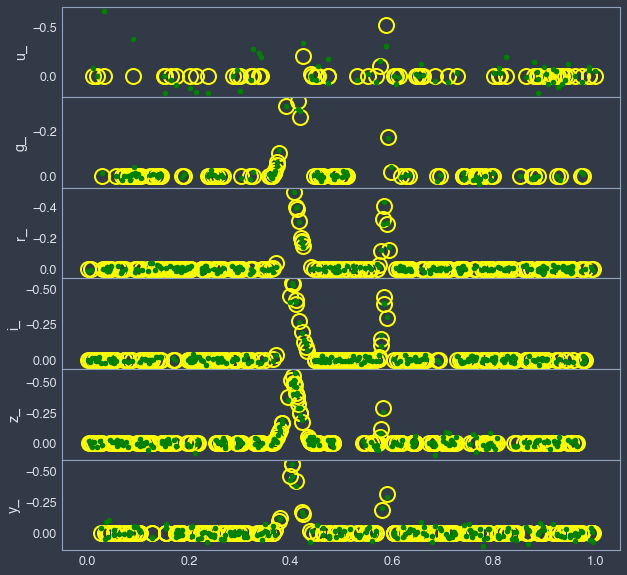

In [17]:
fig,ax = plt.subplots(6,1, figsize=(10,10), sharex = True)
for i,f in enumerate(worker.filters):
    #with crowding
    phase = (worker.EB.obsDates[f] % worker.EB.period)/worker.EB.period
    ax[i].plot(phase, appMag[f] - appMag_noLight3[f],'o',  mec='yellow', mfc='none', mew=2, markersize=15)
    ax[i].plot(phase, appMagObs[f] - appMagObs_noLight3[f],'o', color='green')

    #ax[i].plot(phase, appMagObs_noLight3[f],'.', color='orange')

    ax[i].set_ylim(ax[i].get_ylim()[::-1])
    ax[i].set_ylabel(f)

plt.subplots_adjust(hspace=0)